# Simulation of financial returns

Looking to see how a 'risky' investment will work, starting with a simple model that has good years and bad years, to simulate business cycles.

The first analysis is a simple expected value calculation to translate into an equivalent ARR

The second analysis plays this out, monte-carlo style over 10-20 years, and looking at the raw returns and comparing to expectations.  


In [27]:
#%load_ext autoreload
#%autoreload 2       

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# add data connection
import os
import gspread as gs
import pandas as pd
home_directory = os.path.expanduser("~")
goog_auth_file = "{}/secrets/modeling-general-data-a9fa2233aed5.json".format(home_directory)
gc = gs.service_account(filename=goog_auth_file)

In [4]:
# load parameters
spreadsheet_id ="12froVqa4mGoqglbnZyr_UY8CGl6Oxm_swMZyuh_YmdQ"
sheet = gc.open_by_key(spreadsheet_id)

## Utility Functions

In [5]:
def get_params_from_key(df, key):
    record = df.loc[df.id==key]
    assert(len(record)==1)  # should be 
    params = record.to_dict(orient='records')[0]
    return params

In [6]:
def equilibrium_prob(bull_self, bear_self):
    return (1-bear_self)/(2-bull_self-bear_self)

In [7]:
import random

def sim_sticky_year(p_A, p_B, n_steps, initial_state='bull'):
    """
    Simulate a Monte Carlo trial of a 2-state "sticky switch" Markov chain.

    Parameters:
        p_A (float): Probability of staying in state bull.
        p_B (float): Probability of staying in state bear.
        n_steps (int): Number of steps to simulate.
        initial_state (str): Starting state ('bull' or 'bear').

    Returns:
        list: Sequence of states visited during the simulation.
    """
    if initial_state not in ('bull', 'bear'):
        raise ValueError("Initial state must be 'bull' or 'bear'.")
    if not (0 <= p_A <= 1 and 0 <= p_B <= 1):
        raise ValueError("Probabilities p_A and p_B must be between 0 and 1.")
    
    states = [initial_state]
    current_state = initial_state

    for _ in range(n_steps):
        rand_val = random.random()  # Generate a random number between 0 and 1
        if current_state == 'bull':
            current_state = 'bull' if rand_val < p_A else 'bear'
        elif current_state == 'bear':
            current_state = 'bear' if rand_val < p_B else 'bull'
        states.append(current_state)

    return states


In [8]:
def sim_random_year(p_A, n_steps, initial_state='bull'):
    return choice(['bull', 'bear'], size=(n_steps,), p=[p_A,1-p_A])

## Analysis 1, expected value, default

Using a 20% good return, and a 35% bad return that comes once in five years or so

In [9]:
# load sheet
worksheet = sheet.worksheet("general_setup")
setup_df = pd.DataFrame(worksheet.get_all_records())

In [10]:
# get case
key = 1
gparams = get_params_from_key(setup_df, key)

In [11]:
# assign params
goodret = gparams['bull_year_return']
badret= gparams['bear_year_return']
bull_run_prob= gparams['bull_self_prob']
bear_run_prob= gparams['bear_self_prob']
prob = equilibrium_prob(bull_run_prob, bear_run_prob)


In [12]:
# compute and print
eret = prob*(1+goodret)+(1-prob)*(1+badret)

print(eret)

1.0899999999999999


## Analysis 2, sweep of expected value with changing bad year


In [13]:
worksheet = sheet.worksheet("sweep_bear_year_severity")
sweep_df = pd.DataFrame(worksheet.get_all_records())

In [14]:
key = 's2'
sparams = get_params_from_key(sweep_df, key)

In [15]:
sparams

{'id': 's2',
 'min_bear_return': -0.5,
 'max_bear_return': 0.02,
 'resolution': 0.1}

In [16]:
# Sweep of max negative return

badret = np.arange(sparams['min_bear_return'], sparams['max_bear_return'], sparams['resolution'])
goodret = gparams['bull_year_return']
prob= equilibrium_prob( gparams['bull_self_prob'] , gparams['bear_self_prob'])

eret = prob*(1+goodret)+(1-prob)*(1+badret)


Text(0.5, 1.0, 'Model with 80.0% years with 1.2x gain')

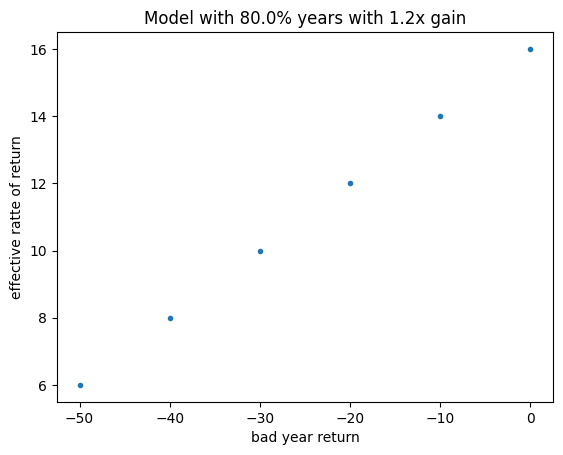

In [17]:
plt.plot(100*badret, 100*(eret-1), '.')
plt.xlabel('bad year return')
plt.ylabel('effective ratte of return')
plt.title('Model with {}% years with {}x gain'.format(100*prob, 1+goodret))

# Monte-Carlo trials

First compare effective RoR with the bad year return, at a given setpoint

In [18]:
worksheet = sheet.worksheet("mc_trials")
mc_df = pd.DataFrame(worksheet.get_all_records())

In [19]:
key = 'mc1'
mcparams = get_params_from_key(mc_df, key)

In [20]:
mcparams

{'id': 'mc1', 'N_trials': 4, 'N_years': 15, 'method': 'random_year'}

In [21]:
from numpy.random import binomial, choice

In [22]:
# extract MC parameters
N = mcparams['N_years']
N_trials = mcparams['N_trials']
sim_method = mcparams['method']

# general parameters
goodret = gparams['bull_year_return']
badret = gparams['bear_year_return']

altret1 = gparams['alt_return_fedfunds']+1
altret2 = gparams['alt_return_2']+1

bull_run_prob= gparams['bull_self_prob']
bear_run_prob= gparams['bear_self_prob']
prob = equilibrium_prob(bull_run_prob, bear_run_prob)



In [23]:
# run expected simulation
periods = np.arange(0,N*12+1,1)
expret = prob*(1+goodret)+(1-prob)*(1+badret)

evalue = np.zeros(np.size(periods))
altvalue = np.zeros(np.size(periods))
altvalue2 = np.zeros(np.size(periods))

evalue[0] = 1.0
altvalue[0] =1.0
altvalue2[0] = 1.0
i=1
for m in range(12*N):
    evalue[i] = evalue[i-1]*(1+(expret-1)/12)
    altvalue[i] = altvalue[i-1]*(1+(altret1-1)/12)
    altvalue2[i] = altvalue2[i-1]*(1+(altret2-1)/12)
    i += 1



In [24]:
# run Ntrials simulations over good vs bad years

Ntrials = 4
value = np.zeros((Ntrials, N*12+1))
for n in range(Ntrials):
    if sim_method == 'random_year':
        yeartype = sim_random_year(bull_run_prob, N)
    elif sim_method == 'sticky_year':
        yeartype = sim_sticky_year(bull_run_prob, bear_run_prob, )        
    value[n,0] = 1.0
    i=1
    for y in yeartype:
        for m in range(12):
            if y=='bull':
                value[n,i] = value[n,i-1]*(1+goodret/12)
            else:
                value[n,i] = value[n,i-1]*(1+badret/12)
            i += 1



Text(0, 0.5, 'Total value')

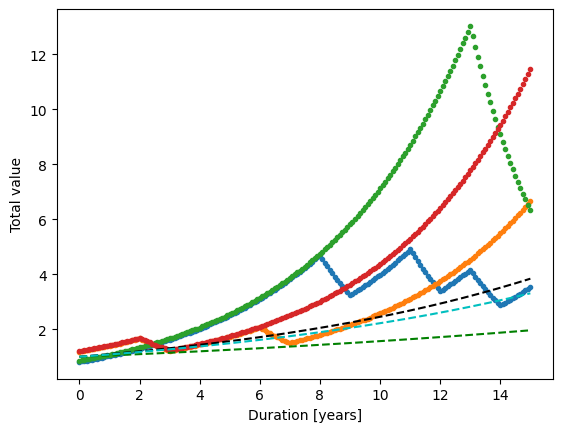

In [25]:
for n in range(Ntrials):
    plt.plot(periods/12, value[n,:]+np.random.rand()/2-0.25, '.')
plt.plot(periods/12, evalue, 'k--')

plt.plot(periods/12, altvalue, 'g--')
plt.plot(periods/12, altvalue2, 'c--')

plt.xlabel('Duration [years]')
plt.ylabel('Total value')




Text(0, 0.5, 'Rate of Return')

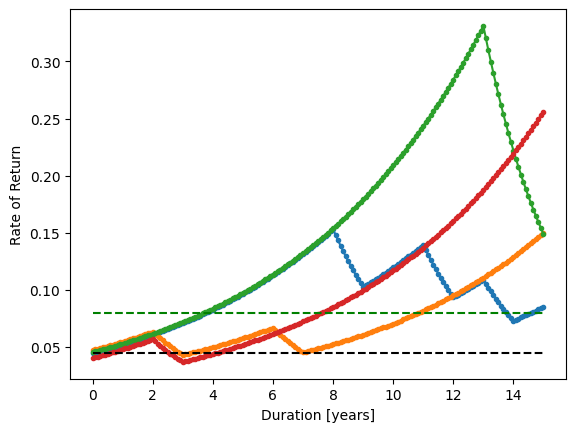

In [26]:
for n in range(Ntrials):
    plt.plot(periods/12, (altret1-1)*((value[n,:]+np.random.rand()/2-0.25)/altvalue), '.-')
plt.plot([0,N],[altret2-1,altret2-1], 'g--')
plt.plot([0,N],[altret1-1,altret1-1], 'k--')

plt.xlabel('Duration [years]')
plt.ylabel('Rate of Return')


